<a href="https://colab.research.google.com/github/sunyeul/ToyProjectLab/blob/feature%2Fpytorch-oop-sample/PyTorch_OOP/04_torchvision_MNIST_mini_batch_train_oop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
class cfg:
    train_batch_size = 64
    val_batch_size = 64
    num_epochs = 10

In [ ]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        # mnist images are (1, 28, 28) (channels, width, height) 
        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 256)
        self.layer_3 = torch.nn.Linear(256, 10)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(x.size(0), -1)
        
        return nn.Sequential(
            self.layer_1,
            self.relu,
            self.layer_2,
            self.relu,
            self.layer_3,
            self.log_softmax
        )(x)

In [ ]:
class MNISTDataModule:
    def __init__(
        self,
        data_dir,
        train_batch_size=64,
        val_batch_size=64,
        ):
        self.data_dir = data_dir
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size

    def prepare_data(self):
        transform = Compose([
            ToTensor(),
            Normalize((0.1307,), (0.3081,))
        ])
        self.train_dataset = MNIST(
            root=self.data_dir,
            train=True,
            download=True,
            transform=transform
        )

    def setup(self):
        self.train_dataset, self.val_dataset = random_split(
            dataset=self.train_dataset,
            lengths=[55_000, 5_000]
        )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.train_batch_size,
            shuffle=True
            )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.val_dataset,
            batch_size=self.val_batch_size,
            shuffle=True
            )

In [ ]:
class Logger:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def log_train_loss(self, loss):
        self.train_losses.append(loss)

    def log_val_loss(self, loss):
        self.val_losses.append(loss)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
class MNISTTrainer:
    def __init__(self, num_epochs, lr=1e-3):
        self.num_epochs = num_epochs
        self.lr = lr

        self.logger = Logger()

    def cross_entropy_loss(self, out, y):
        lossfun = nn.CrossEntropyLoss()
        return lossfun(out, y)

    def configure_optimizers(self, model):
        optimizer = optim.SGD(model.parameters(), lr=self.lr)
        return optimizer 

    def train_step(self, batch):
        x, y = batch
        x = x.view(x.size(0), -1)

        out = self.model(x)

        loss = self.cross_entropy_loss(out, y)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def train_epoch(self, train_dataloader):
        self.model.train()
        train_epoch_loss = 0
        for train_batch in train_dataloader:
            train_batch_loss = self.train_step(batch=train_batch)
            train_epoch_loss += train_batch_loss
        train_epoch_loss /= len(train_dataloader)
        self.logger.log_train_loss(loss=train_epoch_loss)

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch):
        with torch.no_grad():
            x, y= batch
            x = x.view(x.size(0), -1)

            out = self.model(x)

            loss = self.cross_entropy_loss(out, y)
            return loss.item()

    def validate_epoch(self, val_dataloader):
        self.model.eval()
        val_epoch_loss = 0
        for val_batch in val_dataloader:
            val_batch_loss = self.validation_step(batch=val_batch)
            val_epoch_loss += val_batch_loss
        val_epoch_loss /= len(val_dataloader)
        self.logger.log_val_loss(loss=val_epoch_loss)

    def on_validation_epoch_end(self):
        pass

    def train(self, model, data_module):
        self.model = model
        self.data_module = data_module
        self.optimizer = self.configure_optimizers(model=self.model)

        train_dataloader = data_module.train_dataloader()
        val_dataloader = data_module.val_dataloader()

        for _ in tqdm(range(self.num_epochs)):
            self.train_epoch(train_dataloader)
            self.on_train_epoch_end()

            self.validate_epoch(val_dataloader)
            self.on_validation_epoch_end()

In [ ]:
mnist_clf = MNISTClassifier()

mnist_data_module = MNISTDataModule(
    data_dir=os.getcwd(),
    train_batch_size=cfg.train_batch_size,
    val_batch_size=cfg.val_batch_size
)
mnist_data_module.prepare_data()
mnist_data_module.setup()

mnist_trainer = MNISTTrainer(
    num_epochs=cfg.num_epochs
)

In [ ]:
mnist_trainer.train(
    model=mnist_clf,
    data_module=mnist_data_module
)

100%|██████████| 10/10 [01:48<00:00, 10.83s/it]


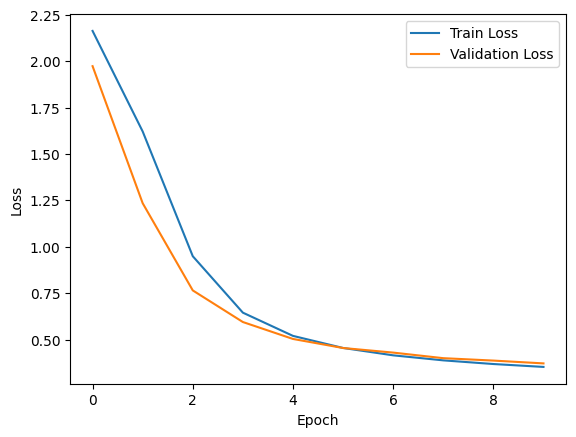

In [ ]:
mnist_trainer.logger.plot_losses()